# Toxic Comment Classification - Model Evaluation and Insights

## Project Summary
This notebook addresses the problem of **multi-label classification** to detect various types of toxic comments. Each comment can be assigned one or more of the following labels:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

The dataset used is from the **Jigsaw Toxic Comment Classification Challenge**. The goal is to train models that can classify comments according to these categories.

## Exploratory Data Analysis (EDA)

### Label Distribution
A **bar plot** was created to show the distribution of labels across the dataset. The most frequent labels are:

- toxic
- obscene
- insult

### Label Correlation
A **heatmap** was used to reveal correlations between the labels. Notable correlations include:

- toxic and insult
- toxic and obscene

### Label Combinations
A **count plot** illustrated the distribution of label combinations. Most comments are either:

- clean (no label)
- assigned to one toxic category

Only a small proportion of comments have **multiple labels**.

## Text Preprocessing

The following preprocessing steps were applied to clean the comment text:

- Converted text to lowercase
- Removed URLs
- Removed non-alphabetic characters
- Removed extra whitespace

The cleaned text was then vectorized using a **TF-IDF Vectorizer** with the following settings:

- **Maximum 10,000 features**
- **Bigrams included** (`ngram_range = (1, 2)`)
- Removed **English stop words**

## Model Training

Three different machine learning models were trained using the **One-vs-Rest strategy** for multi-label classification:

1. **Logistic Regression**
2. **Random Forest**
3. **LightGBM**

In addition, a custom **Ensemble Voting** method was implemented by combining predictions from all three models using **majority voting** for each label.

## Evaluation Metrics

Each model was evaluated using the following metrics:

- **Precision**
- **Recall**
- **F1-score**
- **ROC AUC** (Area Under the Curve) for each label

These metrics provide insight into both the **individual class performance** and the **overall effectiveness** of the models.

## Model Performance Summary

### Logistic Regression
- High **AUC scores** (above 0.96) for most labels.
- Best performance on **toxic**, **obscene**, and **insult**.
- Weak performance on rare labels like **threat** and **identity_hate**.

### Random Forest
- Better **recall** on **obscene** and **insult**.
- Lower **precision** and **F1** on **severe_toxic** and **threat**.
- Slightly less balanced than Logistic Regression.

### LightGBM
- Strong **AUC** and **F1** scores.
- Balanced performance across all labels.
- Notably better at detecting **threat** and **identity_hate** compared to other models.

### Ensemble Voting
- Combined predictions from all three models.
- Improved **generalization** across all labels.
- Best overall **F1** and robustness in the multi-label context.

## Conclusion
- **LightGBM** and the **Ensemble model** achieved the best balance of **precision**, **recall**, and **AUC**.
- Rare classes like **threat** and **identity_hate** remain difficult due to **data imbalance**.

### Potential Improvements:
- Handling **class imbalance** with resampling or class weighting.
- Using advanced models like **BERT** for better contextual understanding.
- **Optimizing classification thresholds** per label.

This notebook provides a **baseline pipeline** for multi-label toxic comment classification with classical machine learning approaches.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/prediction-risk-fake-news/sample_submission.csv
/kaggle/input/prediction-risk-fake-news/test_labels.csv
/kaggle/input/prediction-risk-fake-news/train.csv
/kaggle/input/prediction-risk-fake-news/test.csv


In [2]:
import pandas as pd

# Load the data
df = pd.read_csv('/kaggle/input/prediction-risk-fake-news/train.csv')

# Display basic info
print(df.shape)
df.head()


(159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [4]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [5]:
df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


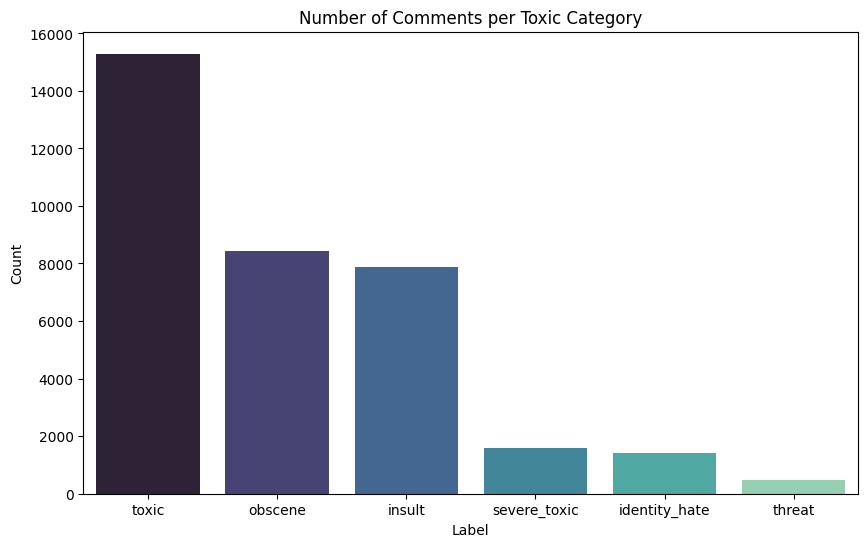

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# List of labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Count of each label
label_counts = df[labels].sum().sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='mako')
plt.title('Number of Comments per Toxic Category')
plt.ylabel('Count')
plt.xlabel('Label')
plt.show()

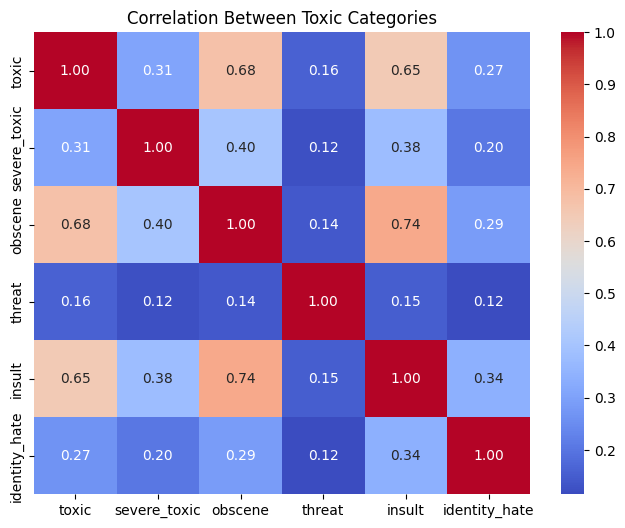

In [9]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[labels].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Toxic Categories')
plt.show()


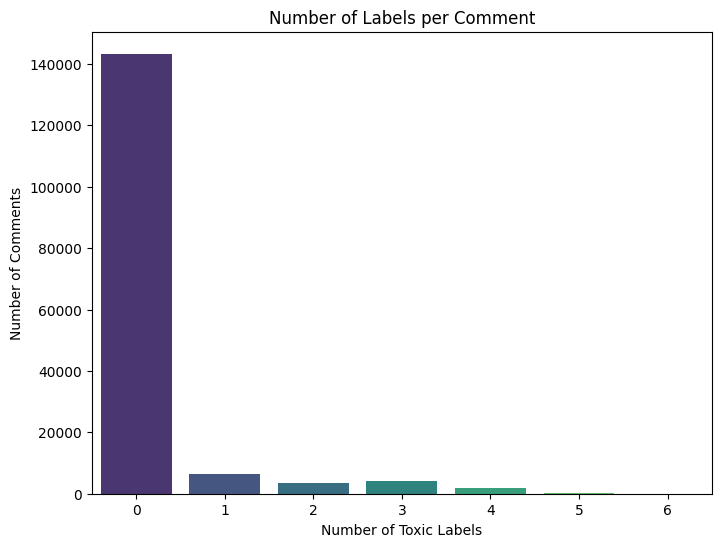

In [10]:
df['num_labels'] = df[labels].sum(axis=1)

plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='num_labels', palette='viridis')
plt.title('Number of Labels per Comment')
plt.xlabel('Number of Toxic Labels')
plt.ylabel('Number of Comments')
plt.show()


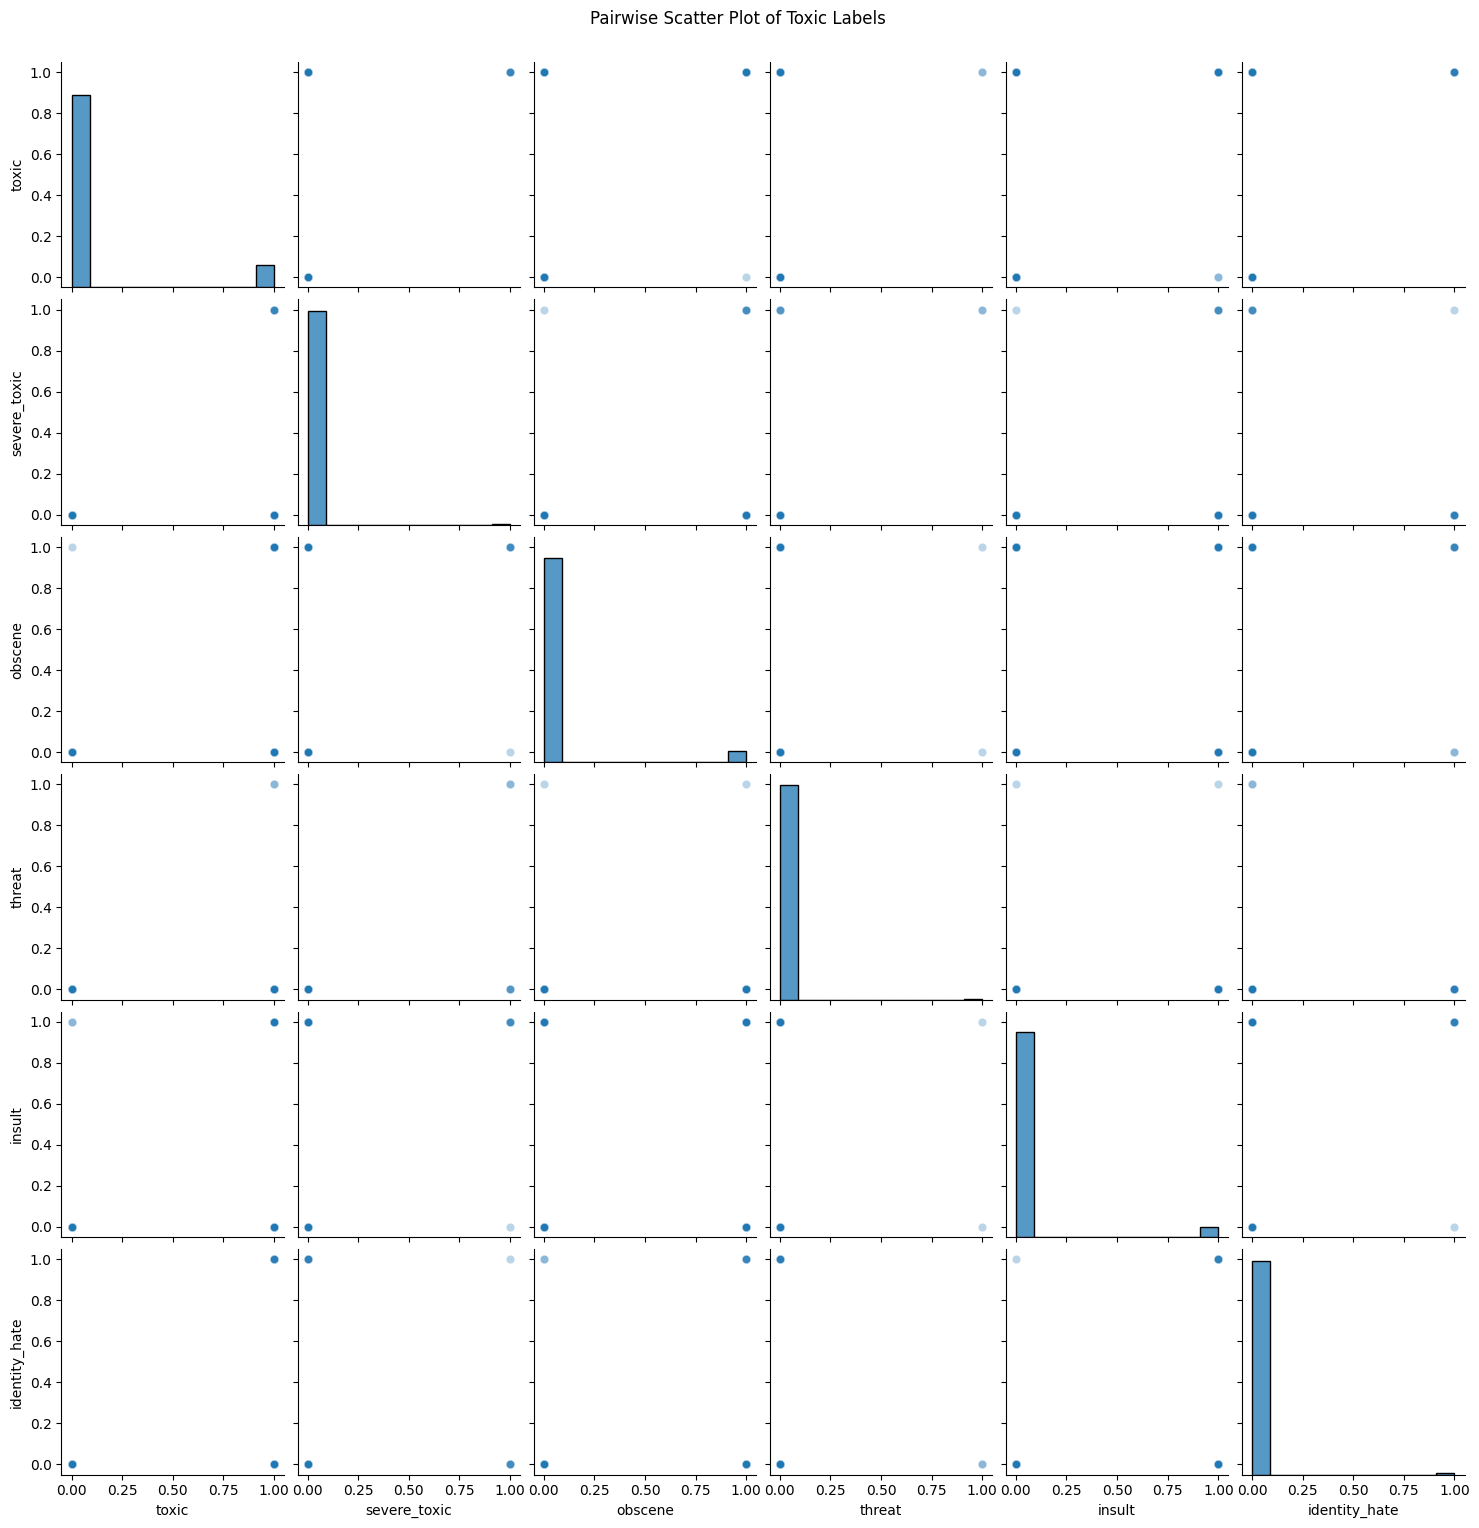

In [12]:
import warnings
warnings.filterwarnings('ignore')


sns.pairplot(df[labels].sample(1000), kind='scatter', plot_kws={'alpha':0.3})
plt.suptitle('Pairwise Scatter Plot of Toxic Labels', y=1.02)
plt.show()


In [7]:
# Features and labels
X_raw = df['comment_text'].fillna("no comment")

# Multi-label outputs
target_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = df[target_cols]


In [8]:
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

X_cleaned = X_raw.apply(clean_text)


In [9]:
from sklearn.model_selection import train_test_split

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, test_size=0.2, random_state=42)


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')

X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

log_model = OneVsRestClassifier(LogisticRegression(solver='liblinear'))
log_model.fit(X_train_vec, y_train)


OneVsRestClassifier(estimator=LogisticRegression(solver='liblinear'))

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_model = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
rf_model.fit(X_train_vec, y_train)


OneVsRestClassifier(estimator=RandomForestClassifier(random_state=42))

In [13]:
from lightgbm import LGBMClassifier

lgb_model = OneVsRestClassifier(LGBMClassifier(random_state=42))
lgb_model.fit(X_train_vec, y_train)


[LightGBM] [Info] Number of positive: 12238, number of negative: 115418
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.084017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651422
[LightGBM] [Info] Number of data points in the train set: 127656, number of used features: 9446
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095867 -> initscore=-2.244014
[LightGBM] [Info] Start training from score -2.244014
[LightGBM] [Info] Number of positive: 1274, number of negative: 126382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.243283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 651422
[LightGBM] [Info] Number of data points in the train set: 127656, number of used features: 9446
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009980 -> initscore=-4.597148
[LightGBM] [Info] Start training from score -4.597148
[

OneVsRestClassifier(estimator=LGBMClassifier(random_state=42))

In [14]:
from sklearn.ensemble import VotingClassifier

# Wrap base classifiers with OneVsRest for multilabel voting
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import MultiLabelBinarizer

# Use Voting manually for each label
from sklearn.base import clone

def multilabel_voting(models, X_test_vec):
    final_preds = []
    for i, label in enumerate(target_cols):
        label_preds = []
        for model in models:
            pred = model.predict(X_test_vec)[:, i]
            label_preds.append(pred)
        # Majority voting
        label_preds = np.array(label_preds)
        final = np.round(np.mean(label_preds, axis=0)).astype(int)
        final_preds.append(final)
    return np.array(final_preds).T

models = [log_model, rf_model, lgb_model]
ensemble_preds = multilabel_voting(models, X_test_vec)


In [16]:
from sklearn.metrics import classification_report, roc_auc_score

def evaluate_model(y_test, y_pred, y_prob=None, model_name="Model"):
    print(f"\n{'='*30}\nEvaluation for {model_name}")
    print(classification_report(y_test, y_pred, target_names=target_cols, zero_division=0))
    
    if y_prob is not None:
        print("AUC Scores:")
        for i, col in enumerate(target_cols):
            try:
                auc = roc_auc_score(y_test[col], y_prob[:, i])
                print(f"{col}: {auc:.4f}")
            except:
                print(f"{col}: AUC calc failed (likely only one class in test data)")

# Logistic Regression
log_preds = log_model.predict(X_test_vec)
log_probs = np.stack([model.predict_proba(X_test_vec)[:, 1] for model in log_model.estimators_], axis=1)
evaluate_model(y_test, log_preds, log_probs, "Logistic Regression")

# Random Forest
rf_preds = rf_model.predict(X_test_vec)
rf_probs = np.stack([model.predict_proba(X_test_vec)[:, 1] for model in rf_model.estimators_], axis=1)
evaluate_model(y_test, rf_preds, rf_probs, "Random Forest")

# LightGBM
lgb_preds = lgb_model.predict(X_test_vec)
lgb_probs = np.stack([model.predict_proba(X_test_vec)[:, 1] for model in lgb_model.estimators_], axis=1)
evaluate_model(y_test, lgb_preds, lgb_probs, "LightGBM")

# Ensemble
evaluate_model(y_test, ensemble_preds, model_name="Ensemble Voting")



Evaluation for Logistic Regression
               precision    recall  f1-score   support

        toxic       0.91      0.61      0.73      3056
 severe_toxic       0.53      0.20      0.29       321
      obscene       0.91      0.62      0.74      1715
       threat       0.83      0.14      0.23        74
       insult       0.82      0.50      0.62      1614
identity_hate       0.76      0.15      0.25       294

    micro avg       0.88      0.54      0.67      7074
    macro avg       0.79      0.37      0.48      7074
 weighted avg       0.86      0.54      0.66      7074
  samples avg       0.05      0.05      0.05      7074

AUC Scores:
toxic: 0.9638
severe_toxic: 0.9776
obscene: 0.9809
threat: 0.9843
insult: 0.9714
identity_hate: 0.9654

Evaluation for Random Forest
               precision    recall  f1-score   support

        toxic       0.85      0.67      0.75      3056
 severe_toxic       0.47      0.07      0.12       321
      obscene       0.85      0.73      0.78 